In [8]:
import torch
from torch import nn
import math
import einops
import numpy as np

torch.manual_seed(42)

In [2]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image as img
from IPython.display import Image, display

In [97]:
path = "../avia-train/0a3e36d7-877b-49a1-85dd-ce1e2d018460.png"

In [98]:
img.open(path)

In [5]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [9]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

print("Trainable parameters amount: {:n}".format(params))

Trainable parameters amount: 86567656


In [99]:
inputs = feature_extractor(images = np.array(img.open(path)), return_tensors="pt")

In [100]:
inputs["pixel_values"].shape

torch.Size([1, 3, 224, 224])

In [101]:
np.array(img.open(path)).shape

(20, 20, 3)

In [102]:
tmp = einops.rearrange(
    (inputs["pixel_values"].squeeze(0).numpy() * 255).astype(np.uint8),
    "c h w -> h w c"
)

tmp.shape

(224, 224, 3)

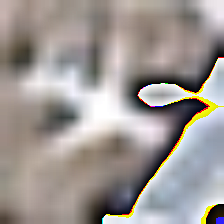

In [103]:
img.fromarray(
    tmp
)

In [104]:
outputs = model(**inputs)
logits = outputs.logits

In [105]:
outputs = model(**inputs)

In [106]:
outputs[0].shape

torch.Size([1, 1000])

In [107]:
logits = outputs.logits

In [108]:
predicted_class_idx = logits.argmax(-1).item()

In [109]:
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: disk brake, disc brake


In [110]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_fea

In [ ]:
nn.Linear(768, 2)

In [10]:
class SelfAttention(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        
        self.sqrt_v = math.sqrt(dim_out) 
        self.to_qkv = nn.Linear(dim_in, 3*dim_out)
        
    def forward(self, x):
        qkv = self.to_qkv(x)
        q, k, v = einops.rearrange(qkv, "h (k w) -> k h w", k=3)

        return torch.sigmoid(q @ k.T) @ v / self.sqrt_v

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, dim_in, dim_out, heads_num):
        super().__init__()
        
        self.heads_num = heads_num
        self.heads = [SelfAttention(dim_in, dim_out) for _ in range(heads_num)]
        self.epic_w = nn.Linear(heads_num * dim_out, dim_in)
        
    def forward(self, x):
        outs = [head(x) for head in self.heads]
        outs = einops.rearrange(outs, "head h w -> h (head w)", head=self.heads_num)
        x = self.epic_w(outs)
        
        return x

In [4]:
x = torch.rand([3, 6])
x

tensor([[0.8823, 0.9150, 0.3829, 0.9593, 0.3904, 0.6009],
        [0.2566, 0.7936, 0.9408, 0.1332, 0.9346, 0.5936],
        [0.8694, 0.5677, 0.7411, 0.4294, 0.8854, 0.5739]])

In [5]:
mha = MultiHeadAttention(6, 4, 2)

In [6]:
a = mha(x)

In [7]:
a

tensor([[ 0.2661,  0.1551, -0.2437, -0.3507, -0.1366, -0.3805],
        [ 0.2552,  0.1484, -0.2105, -0.3468, -0.1555, -0.3830],
        [ 0.2628,  0.1542, -0.2322, -0.3542, -0.1401, -0.3871]],
       grad_fn=<AddmmBackward>)

Parameter containing:
tensor([[ 0.1322, -0.0621, -0.0936,  0.0378, -0.0625, -0.1054,  0.2260,  0.3038],
        [-0.0350, -0.0792,  0.0052, -0.0211,  0.0850,  0.0991, -0.3211, -0.1305],
        [ 0.2977,  0.1377, -0.0176, -0.2132, -0.2163, -0.3167, -0.1152,  0.1194],
        [ 0.2254,  0.1632, -0.3125, -0.2126, -0.0558,  0.3420,  0.0511, -0.0916],
        [ 0.1463, -0.1347, -0.2288,  0.2581, -0.1608, -0.0709, -0.3517,  0.2366],
        [ 0.2679,  0.1289, -0.2465, -0.3489, -0.2871,  0.2636,  0.1697,  0.2975]],
       requires_grad=True)
Parameter containing:
tensor([ 0.1852,  0.0895, -0.0035, -0.2689, -0.3029, -0.3307],
       requires_grad=True)


In [ ]:
encoder -> trsfr -> [mlp -> {classes}]